<a href="https://colab.research.google.com/github/KemasRaihan/Analysis-Of-Common-Words-In-Customer-Reviews-Of-Phones-Using-Neural-Networks/blob/main/Customer_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros

In [ ]:
#For Qualitative Analysis
from itertools import groupby

In [ ]:
# For fixing imbalanced data
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
# For Text Preprocessing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
nltk.download('words')
#nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string

from sklearn.feature_extraction.text import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

import csv
import matplotlib.pyplot as plt
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
# For building the neural networks
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [ ]:
# For evaluation
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

# Other Prequisites

**Epochs**

In [ ]:
EPOCHS = 20

**Read GloVe Embedding**

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/a2_glove.6B.100d.txt'

embeddings_index = dict()
f = open(filepath)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

**Number of Classes**

In [ ]:
# There are 3 classes: negative, neutral and postive
num_of_classes = 3

**Import Raw Dataset**

In [ ]:
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/Amazon_Unlocked_Mobile.csv'

In [ ]:
# Control number of rows to read from csv file
nrows = 1000

df = pd.read_csv(filepath,nrows=nrows, encoding = 'latin')

# Raw Dataset Analysis

In [ ]:
df.shape

(535, 6)

PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships (https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)

In [ ]:
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
8,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
9,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,3,It's battery life is great. It's very responsi...,0.0


In [ ]:
df.isnull().any()

Product Name    False
Brand Name      False
Price           False
Rating          False
Reviews         False
Review Votes    False
dtype: bool

In [ ]:
df = df.dropna()

**Number Of Ratings Of Each Sentiment**

In [ ]:
ratings = df['Rating'].values.tolist()

In [ ]:
ratings[:5]

[5, 4, 5, 4, 4]

In [ ]:
frequency = []

for i in range(1,6):
  frequency.append(ratings.count(i))

In [ ]:
print(frequency)

[136, 57, 42, 61, 239]


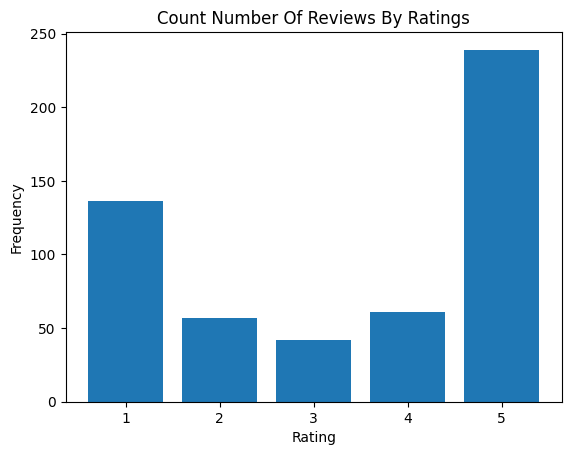

In [ ]:
labels = [1,2,3,4,5]

plt.bar(labels, frequency, width=0.8,  bottom=None, align='center')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Count Number Of Reviews By Ratings')
plt.show()

# Reduce Classes

In [ ]:
df = df.dropna()

In [ ]:
sentiments = []

for rating in ratings:
  # if rating is 1 or 2 (negative) append 0 to sentiments array
  if rating < 3:
    sentiments.append(0)
  # if rating is 3 (neutral), append 1 to sentiments array
  elif rating == 3:
    sentiments.append(1)
  # if rating is 4 or 5 (positive), append 2 to sentiments array
  else:
    sentiments.append(2)


In [ ]:
frequency = []

for i in range(3):
  frequency.append(sentiments.count(i))

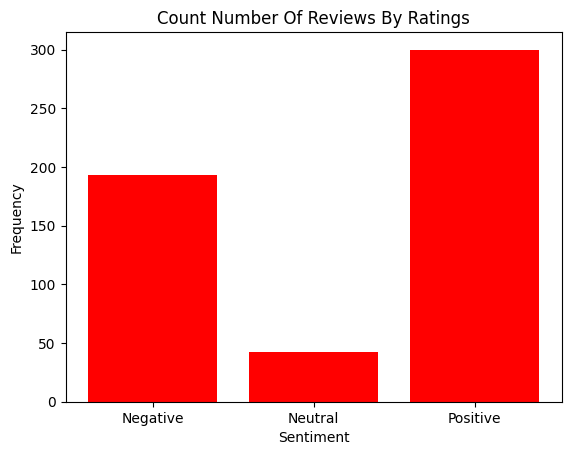

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

plt.bar(labels, frequency, color='red', width=0.8,  bottom=None, align='center')

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Count Number Of Reviews By Ratings')
plt.show()

# Preprocessing Text

In [ ]:
df = df.dropna()

In [ ]:
reviews = df['Reviews']

In [ ]:
reviews.head()

0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object

In [ ]:
#Remove stopwords 'n punctuation
sw = stopwords.words('english')

def preprocess_text(review):
    review = review.lower() # Convert to lowercase
    review = re.sub(r'[^\x00-\x7F]+',' ', review) # Remove words with non-ASCII characters
    words = review.split()
    words = [word for word in words if word not in set(stopwords.words('english'))] # Remove stop words
    review = " ".join(words)
    return review

In [ ]:
reviews = reviews.apply(preprocess_text)

# Tokenize

In [ ]:
def tokenize(review):
  # Convert text to sequences
  encoded_review = t.texts_to_sequences(review)

  # Pad reviews
  padded_review = pad_sequences(encoded_review, maxlen=max_length, padding='post')

  return padded_review

In [ ]:
# Find the length of longest review
max_length = reviews.apply(lambda x: len(x.split())).max()
t = Tokenizer()
t.fit_on_texts(reviews)

vocab_size = len(t.word_index) + 1

# Convert text to sequences
padded_reviews = tokenize(reviews)

In [ ]:
# Map each unique word index with its GloVe vector

embedding_dim = 100

# Initialize an empty matrix with zeros, where the number of rows is determined by the vocabulary size (vocab_size),
# and the number of columns is set to 100, matching the dimensionality of the GloVe word embeddings.
embedding_matrix = np.zeros((vocab_size, 100))

# Iterate through each word in the tokenizer's word index
for word, i in t.word_index.items():
  # Retrieve the GloVe word embedding vector for the current word
    embedding_vector = embeddings_index.get(word)
    # Check if the word has a corresponding embedding in the GloVe model
    if embedding_vector is not None:
      # If an embedding exists, update the corresponding row in the embedding matrix
        # with the GloVe word embedding vector for the current word.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix[:5])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

# Define Training, Validation and Testing Dataset

In [ ]:
one_hot_encoded_Y = pd.get_dummies(sentiments).values

In [ ]:
reviews.shape

(535,)

In [ ]:
one_hot_encoded_Y.shape

(535, 3)

In [ ]:
# Firstly split them into the training dataset and the rest as remaining dataset for validation and testing
train_reviews, remain_reviews, y_train, y_rem = train_test_split(reviews, one_hot_encoded_Y, train_size=0.8, random_state=42)

# Split the remaining dataset for validation and testing
valid_reviews, test_reviews, y_valid, y_test = train_test_split(remain_reviews, y_rem, train_size=0.5)

In [ ]:
print(train_reviews[:5])

294    good thing order 3 pack. poor quality already ...
524      good phone, good qualty, better camera, night..
617    really bad pay conection fee cel charge part w...
598                           lousy phone, speakers work
157    husband loves it!! simple use large numbers. s...
Name: Reviews, dtype: object


In [ ]:
train_reviews_padded = tokenize(train_reviews)

valid_reviews_padded = tokenize(valid_reviews)

In [ ]:
EPOCHS = 20

# Fixing Imbalanced Dataset

# Simple Neural Network (SNN)

In [ ]:
SNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length , trainable=False),
    Flatten(),
    Dense(num_of_classes, activation='softmax')
])

In [ ]:
# Define optimiser for Simple Neural Network model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
SNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
SNN_history = SNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 1s 15ms/step - loss: 1.3897 - acc: 0.4182 - val_loss: 1.3286 - val_acc: 0.4340
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 1.1712 - acc: 0.5958 - val_loss: 1.2815 - val_acc: 0.5472
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 1.0716 - acc: 0.7009 - val_loss: 1.2491 - val_acc: 0.6415
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.9945 - acc: 0.7453 - val_loss: 1.2197 - val_acc: 0.6604
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.9291 - acc: 0.7593 - val_loss: 1.1957 - val_acc: 0.6604
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.8772 - acc: 0.7593 - val_loss: 1.1754 - val_acc: 0.6792
Epoch 7/20
14/14 [==============================] - 0s 6ms/step - loss: 0.8294 - acc: 0.7757 - val_loss: 1.1631 - val_acc: 0.6792
Epoch 8/20
14/14 [==============================] - 0s 5ms/step - loss: 0.7879 - acc: 0.7

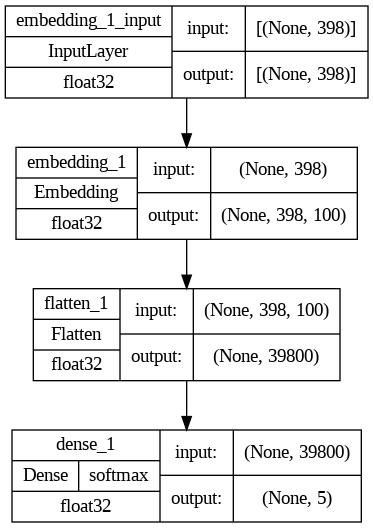

In [ ]:
plot_model(
    SNN,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
def display_graphs(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train','test'], loc='upper left')
  plt.show()


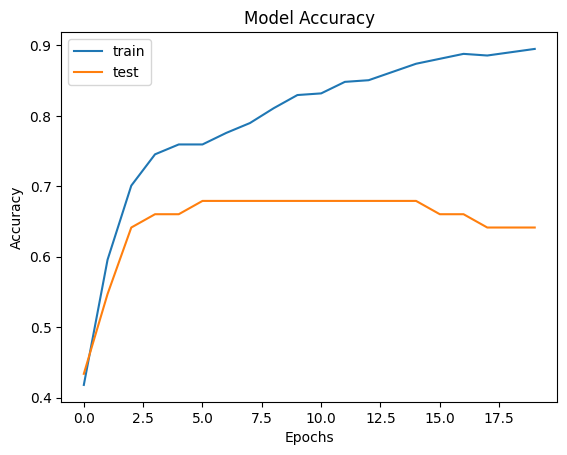

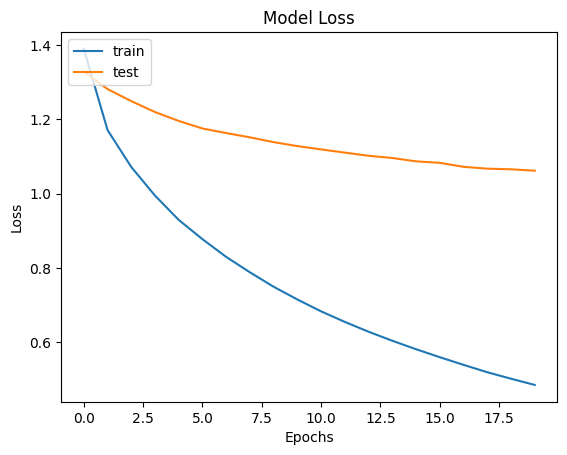

In [ ]:
display_graphs(SNN_history)

In [ ]:
# Define file path to save/load SNN model
filepath_SNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/SNN_rating_predictor.keras'

In [ ]:
# save SNN model
keras.saving.save_model(SNN, filepath_SNN)

# Convolutional Neural Network (CNN)

In [ ]:
CNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(),
    Dense(num_of_classes, activation='softmax')
])

In [ ]:
# Define optimiser for CNN model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
CNN_history = CNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 2s 37ms/step - loss: 1.6121 - acc: 0.3178 - val_loss: 1.4370 - val_acc: 0.3962
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 1.2931 - acc: 0.5280 - val_loss: 1.3694 - val_acc: 0.4528
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 1.1853 - acc: 0.5935 - val_loss: 1.3243 - val_acc: 0.4906
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 1.0980 - acc: 0.6472 - val_loss: 1.2817 - val_acc: 0.5472
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 1.0161 - acc: 0.6916 - val_loss: 1.2430 - val_acc: 0.5472
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.9460 - acc: 0.7103 - val_loss: 1.1873 - val_acc: 0.5472
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.8816 - acc: 0.7477 - val_loss: 1.1592 - val_acc: 0.5660
Epoch 8/20
14/14 [==============================] - 0s 8ms/step - loss: 0.8225 - acc: 0.7

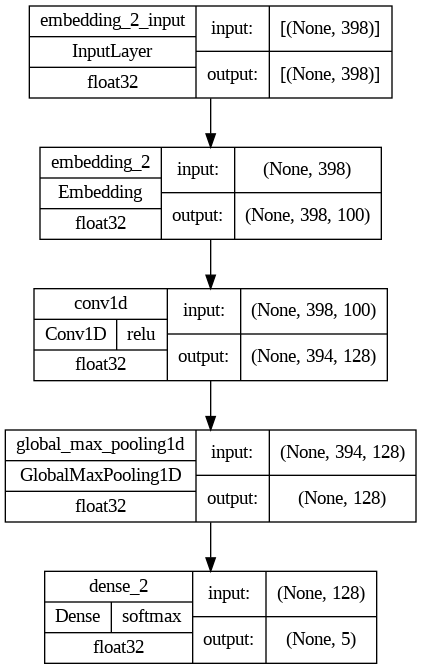

In [ ]:
plot_model(
    CNN,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

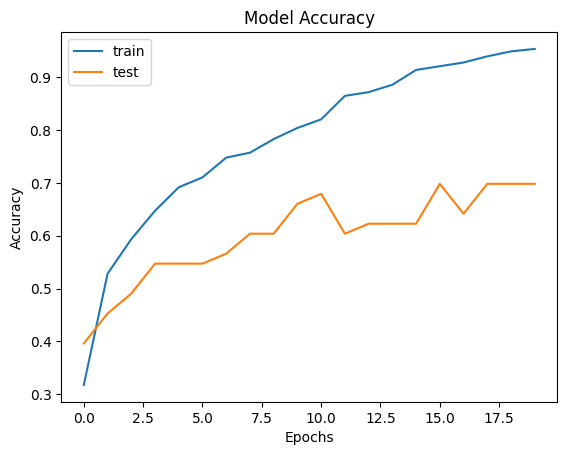

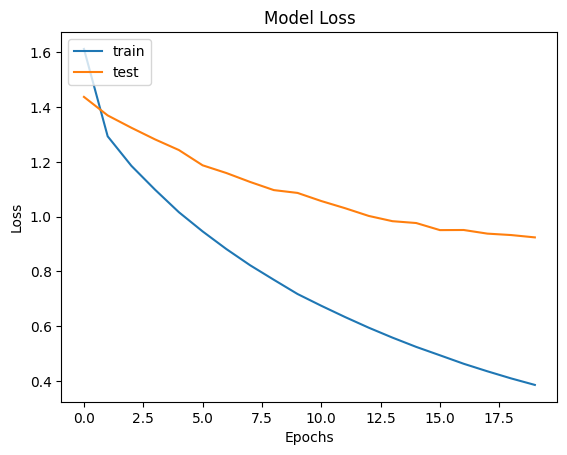

In [ ]:
display_graphs(CNN.history)

In [ ]:
# Define file path to save/load CNN model
filepath_CNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_rating_predictor.keras'

In [ ]:
# save CNN model
keras.saving.save_model(CNN, filepath_CNN)

# Long-Short Term Memory (LSTM)

In [ ]:
# Build an LSTM model
LSTM = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_of_classes, activation='softmax')
])


In [ ]:
# Define optimiser for LSTM model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Train the model
LSTM_history = LSTM.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 19s 1s/step - loss: 1.6001 - acc: 0.4509 - val_loss: 1.5961 - val_acc: 0.4151
Epoch 2/20
14/14 [==============================] - 16s 1s/step - loss: 1.5820 - acc: 0.4626 - val_loss: 1.5800 - val_acc: 0.4151
Epoch 3/20
14/14 [==============================] - 16s 1s/step - loss: 1.5503 - acc: 0.4603 - val_loss: 1.5372 - val_acc: 0.4151
Epoch 4/20
14/14 [==============================] - 17s 1s/step - loss: 1.4326 - acc: 0.4626 - val_loss: 1.4754 - val_acc: 0.4151
Epoch 5/20
14/14 [==============================] - 15s 1s/step - loss: 1.3737 - acc: 0.4626 - val_loss: 1.4854 - val_acc: 0.4151
Epoch 6/20
14/14 [==============================] - 16s 1s/step - loss: 1.3739 - acc: 0.4626 - val_loss: 1.4754 - val_acc: 0.4151
Epoch 7/20
14/14 [==============================] - 18s 1s/step - loss: 1.3743 - acc: 0.4626 - val_loss: 1.4927 - val_acc: 0.4151
Epoch 8/20
14/14 [==============================] - 16s 1s/step - loss: 1.3717 - acc: 0.46

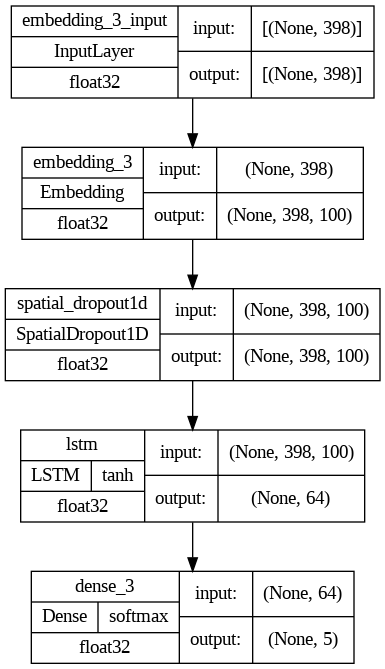

In [ ]:
plot_model(
    LSTM,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

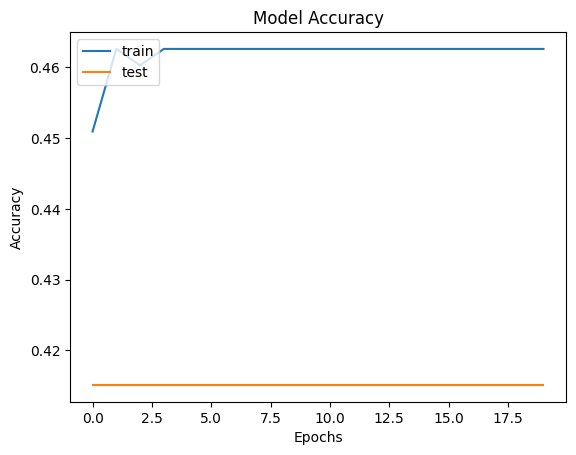

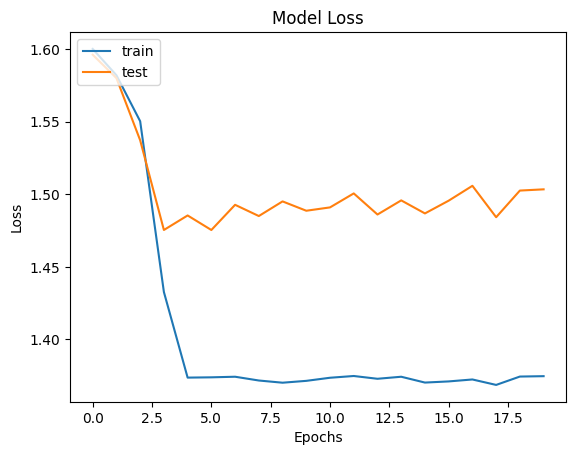

In [ ]:
display_graphs(LSTM.history)

In [ ]:
# Define file path to save/load LSTM model
filepath_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/LSTM_rating_predictor.keras'

In [ ]:
# save LSTM model
keras.saving.save_model(LSTM, filepath_LSTM)

# CNN + LSTM

In [ ]:
CNN_LSTM= Sequential()
CNN_LSTM.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
CNN_LSTM.add(Conv1D(64, kernel_size=5, activation = "relu"))
CNN_LSTM.add(MaxPooling1D(pool_size=4))
CNN_LSTM.add(LSTM(100))
CNN_LSTM.add(Dense(num_of_classes, activation='softmax'))

In [ ]:
# Define optimiser for Hybrid model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Train the model
CNN_LSTM_history = CNN_LSTM.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 14s 292ms/step - loss: 2.2252 - acc: 0.2547 - val_loss: 2.1753 - val_acc: 0.3019
Epoch 2/20
14/14 [==============================] - 2s 154ms/step - loss: 2.0743 - acc: 0.3248 - val_loss: 2.1255 - val_acc: 0.3396
Epoch 3/20
14/14 [==============================] - 2s 168ms/step - loss: 1.9882 - acc: 0.4626 - val_loss: 2.1334 - val_acc: 0.3396
Epoch 4/20
14/14 [==============================] - 3s 182ms/step - loss: 1.9551 - acc: 0.4626 - val_loss: 2.1169 - val_acc: 0.3396
Epoch 5/20
14/14 [==============================] - 2s 139ms/step - loss: 1.9297 - acc: 0.4626 - val_loss: 2.0739 - val_acc: 0.3396
Epoch 6/20
14/14 [==============================] - 2s 139ms/step - loss: 1.9050 - acc: 0.4626 - val_loss: 2.0764 - val_acc: 0.3396
Epoch 7/20
14/14 [==============================] - 2s 171ms/step - loss: 1.8857 - acc: 0.4626 - val_loss: 2.0489 - val_acc: 0.3396
Epoch 8/20
14/14 [==============================] - 2s 165ms/step - loss: 1

In [ ]:
plot_model(
    CNN_LSTM,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

KeyboardInterrupt: 

In [ ]:
display_graphs(CNN_LSTM.history)

In [ ]:
# Define file path to save/load CNN + LSTM model
filepath_CNN_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_LSTM_rating_predictor.keras'

In [ ]:
# save CNN + LSTM model
keras.saving.save_model(CNN_LSTM, filepath_CNN_LSTM)

# CNN + Dense

In [ ]:
CNN_Dense = Sequential()
CNN_Dense.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
CNN_Dense.add(Conv1D(64, 5, activation='relu'))
CNN_Dense.add(MaxPooling1D(pool_size=4))
CNN_Dense.add(Flatten())
CNN_Dense.add(Dense(100, activation='relu'))
CNN_Dense.add(Dense(num_of_classes, acitvation='softmax'))

In [ ]:
# Define optimiser for Hybrid model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_Dense.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Train the model
CNN_Dense_history = CNN_Dense.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

In [ ]:
CNN_Dense.summary()

In [ ]:
plot_model(
    CNN_Dense,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
display_graphs(CNN_Dense.history)

In [ ]:
# Define file path to save/load CNN + Dense model
filepath_CNN_Dense= '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_Dense_rating_predictor.keras'

In [ ]:
# save CNN + Dense model
keras.saving.save_model(CNN_Dense, filepath_CNN_Dense)

# CNN + LSTM + Dense

In [ ]:
CNN_LSTM_Dense = Sequential()
CNN_LSTM.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
CNN_LSTM.add(Conv1D(64, kernel_size=5, activation = "relu"))
CNN_LSTM.add(MaxPooling1D(pool_size=4))
CNN_LSTM.add(LSTM(100))
CNN_Dense.add(Dense(100, activation='relu'))
CNN_Dense.add(Dense(num_of_classes, acitvation='softmax'))

# Load Trained Models

In [ ]:
# Define file path to save/load SNN model
filepath_SNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/SNN_rating_predictor.keras'

# load SNN model
SNN = tf.keras.saving.load_model(
    filepath_SNN, custom_objects=None, compile=True
)

In [ ]:
# Define file path to save/load CNN model
filepath_CNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/CNN_rating_predictor.keras'

# load CNN model
CNN = tf.keras.saving.load_model(
    filepath_CNN, custom_objects=None, compile=True
)

In [ ]:
# Define file path to save/load LSTM model
filepath_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/LSTM_rating_predictor.keras'

# load LSTM model
LSTM = tf.keras.saving.load_model(
    filepath_LSTM, custom_objects=None, compile=True
)

In [ ]:
# Define file path to save/load Hybrid model
filepath_Hybrid = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/Hybrid_rating_predictor.keras'

# load Hybrid model
Hybrid = tf.keras.saving.load_model(
    filepath_Hybrid, custom_objects=None, compile=True
)

# Evaluation

In [ ]:
test_reviews_padded = tokenize(test_reviews)

In [ ]:
def score_accuracy(model):
  # Predictions on the Test Set
  score = model.evaluate(test_reviews_padded, y_test, verbose=1)

  # Model Performance
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

In [ ]:
score_accuracy(SNN)

2/2 [==============================] - 0s 15ms/step - loss: 1.5455 - acc: 0.5556
Test Score: 1.5454810857772827
Test Accuracy: 0.5555555820465088


In [ ]:
score_accuracy(CNN)

2/2 [==============================] - 0s 67ms/step - loss: 1.0857 - acc: 0.5926
Test Score: 1.0857124328613281
Test Accuracy: 0.5925925970077515


In [ ]:
score_accuracy(LSTM)

AttributeError: type object 'LSTM' has no attribute 'evaluate'

**Confusion Matrices**

In [ ]:
# Convert multidimensional y array to a one-dimensional array
def convert_y_to_1D(y):
  return np.argmax(y, axis=1)

In [ ]:
#Create a confusion matrix for a model from the feature space and true labels
def create_confusion_matrix(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Generate matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Normalise confusion matrix rounded to a percentage up to 2 d.p.
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)

  return conf_matrix

In [ ]:
# Display confusion matrix in a seaborn graph
def display_conf_matrix(conf_matrix, ax):

  # Display column with predicted labels
  columns_ = [f'Predicted: {label}' for label in labels]

  # Display X-axis with actual labels
  index_ = [f'Actual: {label}' for label in labels]

  # Convert confusion matrix object to dataframe for display
  conf_matrix_pd = pd.DataFrame(conf_matrix, columns=columns_, index=index_)

  return sns.heatmap(conf_matrix_pd, ax=ax, annot=True, cmap='magma')

In [ ]:
# Create confusion matrix of the training dataset for the SNN model
cm_train_SNN = create_confusion_matrix(SNN, train_reviews_padded, y_train)

# Create confusion matrix of the training dataset for the CNN model
cm_train_CNN = create_confusion_matrix(CNN, train_reviews_padded, y_train)

# Create confusion matrix of the training dataset for the LSTM model
cm_train_LSTM = create_confusion_matrix(LSTM, train_reviews_padded, y_train)

# Create confusion matrix of the validation dataset for the SNN model
cm_valid_SNN = create_confusion_matrix(SNN, valid_reviews_padded, y_valid)

# Create confusion matrix of the validation dataset for the CNN model
cm_valid_CNN = create_confusion_matrix(CNN, valid_reviews_padded, y_valid)

# Create confusion matrix of the validation dataset for the LSTM model
cm_valid_LSTM = create_confusion_matrix(LSTM, valid_reviews_padded, y_valid)

**Confusion Matrices For Training Dataset**

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Training Dataset', fontsize=20)
axes[0].set_title('SNN')
axes[1].set_title('CNN')
axes[2].set_title('LSTM')
display_conf_matrix(cm_train_SNN, axes[0])
display_conf_matrix(cm_train_CNN, axes[1])
display_conf_matrix(cm_train_LSTM, axes[2])
plt.show()

**Confusion Matrices For Validation Dataset**

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Validation Dataset', fontsize=20)
axes[0].set_title('SNN')
axes[1].set_title('CNN')
axes[2].set_title('LSTM')
display_conf_matrix(cm_valid_SNN, axes[0])
display_conf_matrix(cm_valid_CNN, axes[1])
display_conf_matrix(cm_valid_LSTM, axes[2])
plt.show()

**Accuracy, precision, recall and f1 scores**

In [ ]:
#Calculates accuracy, precision, recall, f1 and specificity from predicted and true results
def calc_scores(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Calculate accuracy score
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision score
  precision = precision_score(y_true, y_pred, average='weighted')

  # Calculate recall score
  recall = recall_score(y_true, y_pred, average='weighted')

  # Calculate f1 score
  f1 = f1_score(y_true, y_pred, average='weighted')

  return [accuracy, precision, recall, f1]

In [ ]:
#Define the accuracy, precision, recall and f1 scores of each model for the training dataset
scores_train_SNN = calc_scores(SNN, train_reviews_padded, y_train)
scores_train_CNN = calc_scores(CNN, train_reviews_padded, y_train)
scores_train_LSTM = calc_scores(LSTM, train_reviews_padded, y_train)

#Define the accuracy, precision, recall and f1 scores of each model for the validation dataset
scores_valid_SNN = calc_scores(SNN, valid_reviews_padded, y_valid)
scores_valid_CNN = calc_scores(CNN, valid_reviews_padded, y_valid)
scores_valid_LSTM = calc_scores(LSTM, valid_reviews_padded, y_valid)

In [ ]:
# Define the model names and their scores for both training and validation set
models = {'SNN' : {'Accuracy (Train)' : scores_train_SNN[0],
                  'Accuracy (Valid)' : scores_valid_SNN[0],
                   'Precision (Train)' : scores_train_SNN[1],
                   'Precision (Valid)' : scores_valid_SNN[1],
                   'Recall (Train)' : scores_train_SNN[2],
                  'Recall (Valid)' : scores_valid_SNN[2],
                   'F1 (Train)' : scores_train_SNN[3],
                   'F1 (Valid)' : scores_valid_SNN[3]
                   },
          'CNN' : {'Accuracy (Train)' : scores_train_CNN[0],
                  'Accuracy (Valid)' : scores_valid_CNN[0],
                   'Precision (Train)' : scores_train_CNN[1],
                   'Precision (Valid)' : scores_valid_CNN[1],
                   'Recall (Train)' : scores_train_CNN[2],
                  'Recall (Valid)' : scores_valid_CNN[2],
                   'F1 (Train)' : scores_train_CNN[3],
                   'F1 (Valid)' : scores_valid_CNN[3]
                   },
          'LSTM' : {'Accuracy (Train)' : scores_train_LSTM[0],
                  'Accuracy (Valid)' : scores_valid_LSTM[0],
                   'Precision (Train)' :  scores_train_LSTM[1],
                   'Precision (Valid)' : scores_valid_LSTM[1],
                   'Recall (Train)' :  scores_train_LSTM[2],
                  'Recall (Valid)' : scores_valid_LSTM[2],
                   'F1 (Train)' :  scores_train_LSTM[3],
                   'F1 (Valid)' : scores_valid_LSTM[3]
                   }
          }
#Create a dataframe table of the dictionary of the models
scores = pd.DataFrame(models).T
scores

# Qualitative Analysis

# Live Prediction

**Using `X_test`**

In [ ]:
test_reviews_array = np.asarray(test_reviews)

In [ ]:
print(type(test_reviews))

In [ ]:
y_test = convert_y_to_1D(y_test)

In [ ]:
test_data = {'Review': test_reviews, 'Rating': y_test}

test_df = pd.DataFrame(data=test_data)

In [ ]:
def find_pred(model, X_fold):
  pred = model.predict(X_fold)

  pred = np.argmax(pred, axis=1)

  return pred

In [ ]:
print(len(test_reviews_padded))

In [ ]:
# Passing tokenised instance to the SNN model for predictions
SNN_pred = find_pred(SNN, test_reviews_padded)

# Passing tokenised instance to the CNN model for predictions
CNN_pred = find_pred(CNN, test_reviews_padded)

# Passing tokenised instance to the LSTM model for predictions
LSTM_pred = find_pred(LSTM, test_reviews_padded)


In [ ]:
print(SNN_pred)

In [ ]:
test_df['SNN Prediction'] = SNN_pred

test_df['CNN Prediction'] = CNN_pred

test_df['LSTM Prediction'] = LSTM_pred

In [ ]:
test_df

**User Input**

In [ ]:
example = reviews[0]

print(type(example))

In [ ]:
print(len(example))

In [ ]:
input_review = input("Enter review: ")

input_review_processed = preprocess_text(input_review)

input_review_padded = encode_pad(input_review_processed)

print(input_review_processed)

print(len(input_review))

In [ ]:
input_review = input("Enter review: ")

input_review_processed = preprocess_text(input_review)

input_review_padded = encode_pad(input_review_processed)

SNN_pred = find_pred(SNN, input_review_padded)

CNN_pred = find_pred(CNN, input_review_padded)

LSTM_pred = find_pred(LSTM, input_review_padded)

print("Review: ", input_review)
print("SNN Prediction: ", SNN_pred)
print("CNN Prediction: ", CNN_pred)
print("LSTM Prediction: ", LSTM_pred)